RWARF


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# === Load historical data ===
df = pd.read_csv("/content/climatenasa.csv", skiprows=11)
df.columns = ['year', 'month', 'day', 'temperature', 'humidity', 'rainfall']

def add_features(df, max_rainfall):
    df['season'] = df['month'].apply(lambda x: (x % 12 + 3) // 3)
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
    df['day_of_year'] = df['date'].dt.dayofyear
    df['is_weekend'] = df['date'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)
    df['temp_humidity_ratio'] = df['temperature'] / df['humidity']
    df['humidity_rainfall_product'] = df['humidity'] * df['rainfall']
    df['temp_rainfall_ratio'] = df['temperature'] / (df['rainfall'] + 1e-5)
    df['rainfall_intensity'] = df['rainfall'] / (max_rainfall + 1e-5)
    return df

# === Feature engineering ===
max_rainfall = df['rainfall'].max()
df = add_features(df, max_rainfall)
features = [
    'year', 'month', 'day', 'season', 'temperature', 'humidity',
    'day_of_year', 'is_weekend', 'temp_humidity_ratio',
    'humidity_rainfall_product', 'temp_rainfall_ratio', 'rainfall_intensity'
]
X_hist = df[features]
y_hist = df['rainfall']

scaler = StandardScaler()
X_hist_scaled = scaler.fit_transform(X_hist)

# === Load real-time test data ===
real_df = pd.read_csv("/content/may2025data.csv")
real_df = add_features(real_df, max_rainfall)
X_real = real_df[features]
y_real = real_df['rainfall']
X_real_scaled = scaler.transform(X_real)

# === Step 1: Initial training ===
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_hist_scaled, y_hist)
y_pred_real = rf.predict(X_real_scaled)

# === Step 2: Calculate reward (negative squared error) ===
errors = (y_pred_real - y_real.values) ** 2
rewards = -errors

# Normalize rewards to create sample weights (larger error = larger weight)
weights = errors / np.max(errors) + 1e-6  # avoid 0
weights = weights / np.sum(weights)

# === Step 3: Create RL-tuned dataset by merging historical and weighted real-time data ===
X_combined = np.vstack([X_hist_scaled, X_real_scaled])
y_combined = np.concatenate([y_hist, y_real])
sample_weights = np.concatenate([np.ones_like(y_hist), weights * len(y_hist)])  # match scale

# === Step 4: Re-train with reward-based weighted samples ===
rf_rl_tuned = RandomForestRegressor(n_estimators=100, random_state=42)
rf_rl_tuned.fit(X_combined, y_combined, sample_weight=sample_weights)

# === Step 5: Evaluate updated model ===
y_real_pred_updated = rf_rl_tuned.predict(X_real_scaled)
mse_updated = mean_squared_error(y_real, y_real_pred_updated)

print(f"\n🎯 MSE Before RL-style Tuning: {mean_squared_error(y_real, y_pred_real):.6f}")
print(f"✅ MSE After RL-style Tuning:  {mse_updated:.6f}")


🎯 MSE Before RL-style Tuning: 0.000256
✅ MSE After RL-style Tuning:  0.000031


BACKTESTING


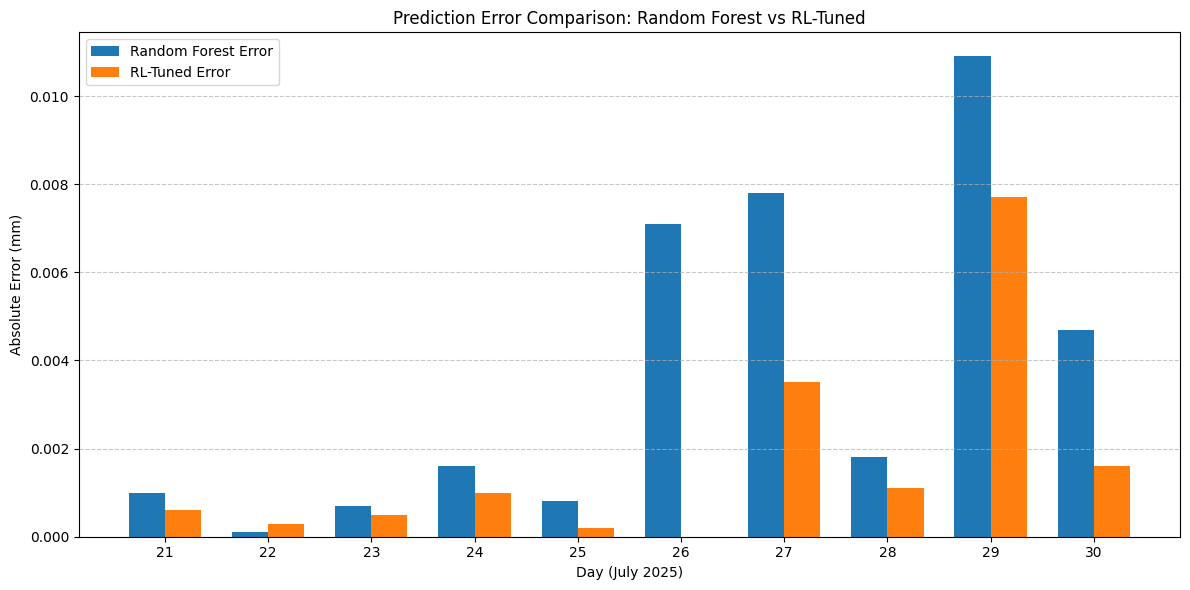

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data (replace this with your actual DataFrame or CSV read)
data = {
    'day': [21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    'actual_rainfall': [5.10, 4.85, 6.10, 6.36, 25.56, 16.28, 11.90, 8.84, 17.25, 17.57],
    'predicted_base': [5.1010, 4.8499, 6.1007, 6.3616, 25.5608, 16.2871, 11.9078, 8.8418, 17.2609, 17.5747],
    'predicted_rl_tuned': [5.0994, 4.8503, 6.1005, 6.3610, 25.5602, 16.2800, 11.9035, 8.8389, 17.2577, 17.5716]
}

df = pd.DataFrame(data)

# Calculate absolute errors
df['error_base'] = abs(df['actual_rainfall'] - df['predicted_base'])
df['error_rl'] = abs(df['actual_rainfall'] - df['predicted_rl_tuned'])

# Bar plot
x = np.arange(len(df['day']))  # the label locations
width = 0.35  # the width of the bars

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, df['error_base'], width, label='Random Forest Error')
plt.bar(x + width/2, df['error_rl'], width, label='RL-Tuned Error')

plt.xlabel('Day (July 2025)')
plt.ylabel('Absolute Error (mm)')
plt.title('Prediction Error Comparison: Random Forest vs RL-Tuned')
plt.xticks(x, df['day'])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
